In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from tqdm.notebook import tqdm

# Pytorch Dataset for MNIST

In [2]:
class Mnist(Dataset):
    def __init__(self, img_gzip, label_gzip, base_dir):
        self.img_gzip_path = base_dir + img_gzip
        self.label_gzip_path = base_dir + label_gzip
        self.imgs, self.labels = None, None
        self.load()
        
    def load(self):
        with open(self.img_gzip_path,'rb') as f:
            magic, size = struct.unpack(">II", f.read(8))
            nrows, ncols = struct.unpack(">II", f.read(8))
            self.imgs = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))\
                     .reshape((size, nrows, ncols, 1))
            self.imgs = np.transpose(self.imgs, (0,3,1,2))

        with open(self.label_gzip_path,'rb') as f:
            magic, size = struct.unpack('>II', f.read(8))
            self.labels = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.imgs[idx], dtype=torch.float32)/255.0
        label = torch.tensor(self.labels[idx])
        return img, label

In [3]:
base_dir = 'data/mnist/'

img_gzip = "train-images.idx3-ubyte"
label_gzip = "train-labels.idx1-ubyte"

test_img_gzip = "t10k-images.idx3-ubyte"
test_label_gzip = "t10k-labels.idx1-ubyte"

In [4]:
dataset = Mnist(img_gzip = img_gzip,
                label_gzip = label_gzip,
                base_dir = base_dir)

test_dataset = Mnist(img_gzip = test_img_gzip,
                label_gzip = test_label_gzip,
                base_dir = base_dir)

In [5]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

In [6]:
def plot_img(img):
    plt.figure(figsize=(3,3))
    plt.imshow(img)

In [7]:
img, label = next(iter(dataloader))

## How to create the patches?

The input to the transformer encoder is the embedded transformation of a patch. We achieve this in one go by using a convolution layer with the kernel size as the size of the patch and the stride as well as the size of the patch.  

In [8]:
patch_size = 4
num_patches = img.shape[-1]//patch_size
print("Number of patches along 1 dim: ", num_patches)

Number of patches along 1 dim:  7


In [9]:
embedding_dim = 16

In [10]:
break_patches = nn.Conv2d(in_channels = 1, 
                          out_channels = embedding_dim, 
                          kernel_size = patch_size, 
                          stride = patch_size)

The above convolution is a pretty interesing way to break into patches and apply embedding : 
* It applies a kernel mapping to each element of the image on which the kernel overlaps which is basically an element wise summation after multiplying with the kernel weights.
* The number of output channel corresponds to the embedding dim. So we have "embedding-dim" number of filters. Focus on the first patch that is the first time a kernel is applied on the top-left corner. The output of that is a scalar value. For a particualr kernel, we will be transforming along each of the patch resulting in a [num_patch $\times$ num_patch]. We will have this for each of the filters i.e. "embedding-dim" number resulting in the shape [ embedding_dim $\times$ num_patch $\times$ num_patch]. We flatten the last two dimension i.e. flattening along the patches for each each kernel.
* The last two dimension is now transposed. For each of the patch, we have a value corresponding to each of the kernel resulting in [embedding_dim] number of "dimensions"

In [11]:
patch_embedding = break_patches(img)
print("Shape after Convolution : " , patch_embedding.shape)
print("Shape after Flattening : " , patch_embedding.flatten(start_dim = -2).shape)
print("Shape after Flattening : " , torch.transpose(patch_embedding.flatten(start_dim = -2), -1,-2).shape)

Shape after Convolution :  torch.Size([32, 16, 7, 7])
Shape after Flattening :  torch.Size([32, 16, 49])
Shape after Flattening :  torch.Size([32, 49, 16])


In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, input_channel, patch_size, embedding_dim, 
                       num_patch, batch_size):
        super().__init__()
        self.patch_layer = nn.Conv2d(input_channel, embedding_dim, 
                                     kernel_size = patch_size, 
                                     stride = patch_size)
        
        # The class token is inherently the embedding of the image that goes into the final MLP layer
        self.class_token = nn.Parameter(torch.randn(batch_size, embedding_dim, 1))
        
        # Position embedding is applied to capture the relative position of the patches in the image
        self.positional_embedding = nn.Parameter(torch.randn(embedding_dim, num_patch + 1))

    def forward(self, x):
        x = self.patch_layer(x) # batch_size x embedding_dim x height x width
        x = x.flatten(start_dim = -2) # batch_size x embedding_dim x (height x width)
        x = torch.cat([self.class_token, x], dim = -1) # batch_size x embedding_dim x (height x width + 1)
        x  = x + self.positional_embedding
        x = torch.transpose(x, -2, -1) #batch_size x (height x width + 1)x embedding_dim
        return x

In [13]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, projection_dim, num_heads = 1):
        """
        This forms the core of the Transformer encoder. Using the nn.MultiheadAttention really simplifies
        the actual implementation of the attention. 

        The transformer encoder stack comprises of the attention part followed by the MLP or a linear layers
        with a GeLU activation. 

        The transformer stack is usually increased on top of each other
        """
        super().__init__()
        # Normalizing layer that normalizes along the last dimension
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        # Pytorch MultiheadAttention really simplifies the actual coding of attention part
        self.self_attention = nn.MultiheadAttention(embedding_dim, num_heads, batch_first = True)

        # A linear transformation is also applied 
        self.mlp_block = nn.Sequential(*[
            nn.Linear(embedding_dim, projection_dim), 
            nn.GELU(), 
            nn.Linear(projection_dim, embedding_dim),
        ])

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.self_attention(x,x,x)[0] + x
        x = self.mlp_block(x) + x
        
        return x

In [14]:
class Model(nn.Module):
    def __init__(self, patch_size, 
                 output_dim, NUM_PATCH, BATCH_SIZE,
                 L = 2, input_channel = 1, 
                 embedding_dim = 16, projection_dim = 16, num_heads = 2):
        """
        Forms the entire Visual Transformer model. 
        """
        super().__init__()
        self.patch_embedding = PatchEmbedding(input_channel, 
                                              patch_size, embedding_dim, 
                                              NUM_PATCH, BATCH_SIZE)

        # Mutliple layers of the transformer encoder is stacked on top of another.
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim, projection_dim = embedding_dim) for _ in range(L)])

        # The last layer takes the class token and gives the probability over the classes
        self.output_layer = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer_encoder(x)            
        x = x[:, 0, :] # Extracting the class token
        x = self.output_layer(x)
        return x

In [15]:
device = torch.device('mps')

In [16]:
NUM_PATCH = (img.size(-1) // patch_size) ** 2
BATCH_SIZE = batch_size

In [17]:
model = Model(patch_size = patch_size, output_dim = 10, L=4,
              NUM_PATCH = NUM_PATCH, BATCH_SIZE = BATCH_SIZE).to(device)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
def evaluate(model, dataloader):
    model.eval()
    loss_ = []
    acc = 0
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = loss_fn(output, y_batch)

        output = torch.argmax(output, dim =  -1)
        output = (output == y_batch).sum()
        acc += output.item() / x_batch.size(0)
        loss_.append(loss.item())
    
    acc = acc / len(dataloader)
    loss_ = np.mean(loss_)
    return loss_, acc

In [20]:
epochs = 20
history = {'loss':[]}
for epoch in tqdm(range(epochs)):
    acc, loss_ = 0, []
    model.train()
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        
        acc += (torch.argmax(output, dim = -1) == y_batch).sum() / x_batch.size(0)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())

    acc = acc / len(dataloader)
    loss_ = np.mean(loss_)
    history['loss'].append(loss_)
    
    test_loss, test_acc = evaluate(model, test_dataloader)
    print(f"[{epoch+1}] Loss : {loss_:.4f} Acc : {acc : .2f} \
    Test Loss : {test_loss: .4f} Test Acc : {test_acc : .2f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[1] Loss : 1.1220 Acc :  0.60     Test Loss :  0.4636 Test Acc :  0.86
[2] Loss : 0.3892 Acc :  0.88     Test Loss :  0.3253 Test Acc :  0.90
[3] Loss : 0.2948 Acc :  0.91     Test Loss :  0.2987 Test Acc :  0.91
[4] Loss : 0.2501 Acc :  0.92     Test Loss :  0.2471 Test Acc :  0.92
[5] Loss : 0.2238 Acc :  0.93     Test Loss :  0.2189 Test Acc :  0.93
[6] Loss : 0.2050 Acc :  0.94     Test Loss :  0.1950 Test Acc :  0.94
[7] Loss : 0.1928 Acc :  0.94     Test Loss :  0.1733 Test Acc :  0.95
[8] Loss : 0.1801 Acc :  0.94     Test Loss :  0.1737 Test Acc :  0.95
[9] Loss : 0.1694 Acc :  0.95     Test Loss :  0.1475 Test Acc :  0.95
[10] Loss : 0.1628 Acc :  0.95     Test Loss :  0.1605 Test Acc :  0.95
[11] Loss : 0.1556 Acc :  0.95     Test Loss :  0.1459 Test Acc :  0.95
[12] Loss : 0.1495 Acc :  0.95     Test Loss :  0.1282 Test Acc :  0.96
[13] Loss : 0.1445 Acc :  0.95     Test Loss :  0.1650 Test Acc :  0.95
[14] Loss : 0.1405 Acc :  0.96     Test Loss :  0.1647 Test Acc :  0.95
[

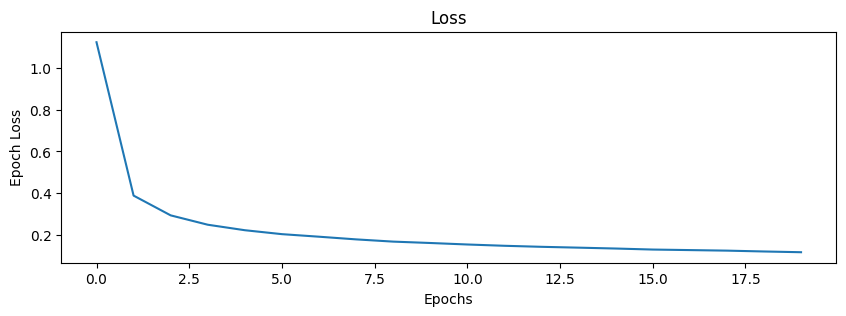

In [21]:
plt.figure(figsize=(10,3))
plt.plot(history['loss'])
_ = plt.gca().set(title='Loss', xlabel='Epochs', ylabel='Epoch Loss')